# 2/20/2025 Lensless IDEAL Optimization - clean and using scripts for all the additional functions.
Building off of the IDEAL example notebook from the main directory and then adapting Eric's old lenslets code for this.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
# set gpu to be pci bus id
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# set gpu memory usage and turnoff pre-allocated memory
# TODO use the MI version for this, the helper function
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] ='false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import optax
import equinox as eqx
import jax
import jax.tree_util as jtu
import jax.numpy as jnp
test = jnp.zeros((10,10,10))
import jax.random as random

import sys 
sys.path.append('/home/lakabuli/workspace/EncodingInformation/src/')
sys.path.append('//home/lakabuli/workspace/EncodingInformation/ideal/') # need this one to import the correct imaging system base class
from imaging_system import ImagingSystem, ImagingSystemProtocol

from encoding_information.models.pixel_cnn import PixelCNN
from encoding_information.models.gaussian_process import FullGaussianProcess
from encoding_information.information_estimation import *

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display
import wandb
wandb.login()

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from losses import PixelCNNLoss, GaussianLoss, GaussianEntropyLoss
from optimizers import IDEALOptimizer, param_labels

# import specific imaging system's modules 
from lensless_imaging_system import RMLPSFLayer
from lensless_data_generator import LenslessDataGenerator


2025-03-01 22:12:52.754489: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-01 22:12:52.754543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-01 22:12:52.755978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 22:12:53.815593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
wandb: Currently logged in as: emarkley (wallerlab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Define a Lensless Imaging System

In [2]:
class LenslessImagingSystem(ImagingSystem):
    psf_layer: RMLPSFLayer
    seed: int = eqx.field(static=True)
    rng_key: jax.random.PRNGKey = eqx.field(static=True)

    def __init__(self, psf_layer, seed: int = 0):
        super().__init__(seed)
        self.psf_layer = psf_layer 
        self.seed = seed 
        self.rng_key = random.PRNGKey(seed)

    @eqx.filter_jit 
    def __call__(self, objects: jnp.ndarray) -> jnp.ndarray:
        """JIT-compiled forward pass."""
        return self.forward_model(objects)
    
    def forward_model(self, objects: jnp.ndarray) -> jnp.ndarray:   
        """ Runs forward model for lensless imaging system. 

        Args:
            objects: Input objects of shape (H, W). 
        
        Returns:
            measurements: Output measurements of shape (H, W)
        """
        key = self.next_rng_key()
        x = self.psf_layer(objects, key=key) 
        # clip the output to be non-negative 
        x = jnp.where(x < 1e-8, 1e-8, x) 
        return x
    
    def reconstruct(self, measurements: jnp.ndarray) -> jnp.ndarray:
        """
        Performs reconstruction from the measurements.

        Args:
            measurements: Input measurements of shape (H, W).

        Returns:
            reconstructions: Reconstructed objects of shape (H, W).
        """
        # Placeholder: Implement reconstruction logic if available.
        # TODO: do a simple deconvolution, something like Wiener deconvolution or ADMM or FISTA 
        return measurements
    
    def toy_images(self, batch_size: int, height: int, width: int) -> jnp.ndarray: 
        """ 
        Generates toy images for testing the system. 
        
        Args: 
            batch size: Number of images to generate.
            height: Height of each image. 
            width: Width of each image.
            
        Returns: 
            Toy images of shape (batch_size, height, width)."""
        key = self.next_rng_key() 
        return random.uniform(key, shape=(batch_size, height, width), minval=0, maxxval=1) 
    
    def display_measurement(self, measurement: jnp.ndarray) -> None:
        fig, ax = plt.subplots(figsize=(5, 5))
        im = ax.imshow(measurement, cmap='gray')
        fig.colorbar(im, ax=ax)
        plt.close()

        return fig
    
    def display_object(self, object: jnp.ndarray) -> None:
        fig, ax = plt.subplots(figsize=(5, 5))
        im = ax.imshow(object, cmap='gray') # running single-channel so no max 
        plt.close()

        return fig

    def display_optics(self) -> None:
        # Create figure with 3 subplots
        fig = plt.figure(figsize=(5, 5))
        
        # 1. PSF Plot (left)
        ax1 = fig.add_subplot(111)
        im1 = ax1.imshow(self.psf_layer.compute_psf(), cmap='gray')
        fig.colorbar(im1, ax=ax1)
        ax1.set_title('PSF')
        ax1.axis('off')
        
        # Adjust layout
        plt.tight_layout()
        plt.close()

        return fig
    
    def display_reconstruction(self) -> None:
        # this is going to display a reconstruction image in the future, but for now I'm going to use it to just display wherever the PSF is nonzero 
        # Create figure with 3 subplots
        fig = plt.figure(figsize=(5, 5))

        # 1. PSF Plot (left)
        ax1 = fig.add_subplot(111)
        im1 = ax1.imshow((self.psf_layer.compute_psf()) > 0, cmap='gray')
        fig.colorbar(im1, ax=ax1)
        ax1.set_title('PSF')
        ax1.axis('off')
        
        # Adjust layout
        plt.tight_layout()
        plt.close()

        return fig
    
    def normalize_psf(self):
        new_psf_layer = self.psf_layer.normalize_psf()
        return eqx.tree_at(lambda m: m.psf_layer, self, new_psf_layer)
    
    def normalize(self):
        """Run all normalization and update steps.
        
        Returns:
            Updated lensless imaging system with normalized PSF.
        """
        system = self.normalize_psf()
        return system
    

# Define Imaging System Parameters

In [3]:
# general parameters 
seed_value = 42
key = jax.random.PRNGKey(seed_value) # TODO change as needed

# dataset parameters 
subset_fraction = 1.0
photon_count = 100.0 # keep as float
tile_rows = 3
tile_cols = 3
batch_size = 50
dataset_name = 'mnist' # 'mnist' or 'cifar10' # TODO change as needed


# RMLPSFLayer parameters 
object_size = 96 
num_gaussian = 25 # TODO changing this
psf_size = (32, 32) 

# define parameters for IDEAL optimization 
patch_size = 16 # default is 16
num_patches = 1024 
patching_strategy = 'random' 
num_steps = 2000 
loss_type = 'pixelcnn' # TODO change as needed
# these are pixelcnn loss-specific parameters
refit_every = 50 # normally it's every 50 
refit_patience = 5 # default is 5
refit_learning_rate = 1e-3 # default is 4e-3 
refit_steps_per_epoch = 100 # default is 100 
gaussian_sigma = None # if none, Poisson noise is used. Otherwise Gaussian noise with standard deviation gaussian_sigma

# wandb parameters
use_wandb=True
project_name='ideal_development'
run_name='{}_loss_patch_16_reinitializing_refit_{}_patience_{}_lr_{}_steps_per_epoch_{}_init_{}'.format(loss_type, refit_every, refit_patience, refit_learning_rate, refit_steps_per_epoch, num_gaussian) # TODO change with each experiment
log_every = 20
validate_every = 500

# Create wandb config dictionary with grouped parameters
wandb_config = {
    'general': {
        'seed_value': seed_value,
    },
    
    'dataset': {
        'subset_fraction': subset_fraction,
        'photon_count': photon_count,
        'tile_rows': tile_rows,
        'tile_cols': tile_cols,
        'batch_size': batch_size,
        'dataset_name': dataset_name,
    },
    
    'psf_layer': {
        'object_size': object_size,
        'num_gaussian': num_gaussian,
        'psf_size': psf_size,
    },
    
    'optimization': {
        'patch_size': patch_size,
        'num_patches': num_patches,
        'patching_strategy': patching_strategy,
        'num_steps': num_steps,
        'loss_type': loss_type,
        'refit_every': refit_every,
        'refit_patience': refit_patience,
        'refit_learning_rate': refit_learning_rate,
        'refit_steps_per_epoch': refit_steps_per_epoch,
        'gaussian_sigma': gaussian_sigma,
    },
    
    'logging': {
        'use_wandb': use_wandb,
        'project_name': project_name,
        'run_name': run_name,
        'log_every': log_every,
        'validate_every': validate_every
    }
}

# Create Your Imaging System

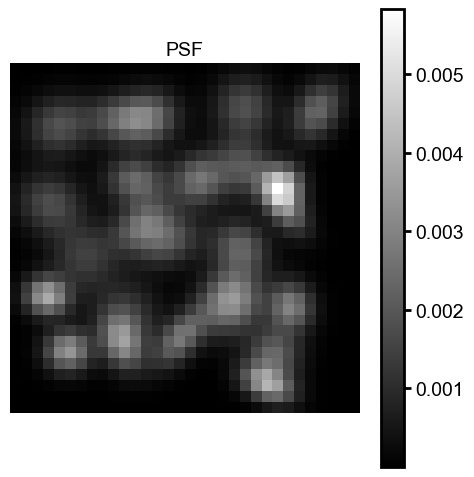

In [4]:
# define the PSF layer
psf_layer = RMLPSFLayer(object_size, num_gaussian, psf_size, key=key)

# Define the imaging system
imaging_system = LenslessImagingSystem(psf_layer)
imaging_system.display_optics()

# Choose Your Learning Rate

In [5]:
labels = param_labels(imaging_system)

Learnable parameters:
psf_layer.means
psf_layer.covs
psf_layer.weights


In [6]:
pl_means_lr = 3e-2
pl_covs_lr = 1e-3
pl_weights_lr = 1e-4 # TODO change

optimizer = optax.multi_transform(
    {
        'psf_layer.means': optax.adam(learning_rate=pl_means_lr),
        'psf_layer.covs': optax.adam(learning_rate=pl_covs_lr),
        'psf_layer.weights': optax.adam(learning_rate=pl_weights_lr)
    },

    param_labels = labels 
)

# Create a Dataset

In [7]:
# Create a Data Generator 
data_generator = LenslessDataGenerator(photon_count, subset_fraction=subset_fraction, seed=seed_value) # currently the data loaded is auto-scaled to photon count.
# TODO alternative approach is to scale it in the training and test datasets. 

# Load CIFAR10 data 
if dataset_name == 'cifar10':
    x_train, x_test = data_generator.load_cifar10_data()
elif dataset_name == 'mnist':
    x_train, x_test = data_generator.load_mnist_data()
else:
    raise ValueError(f"Unknown dataset: {dataset_name}")

# create training dataset with 3x3 tiled images 
train_dataset = data_generator.create_dataset(
    x_train, 
    tile_rows=tile_rows,
    tile_cols=tile_cols,
    batch_size=batch_size   
)
# TODO: incorporate test + validation datasets once those features are included
test_dataset = data_generator.create_dataset(
    x_test, 
    tile_rows=tile_rows,
    tile_cols=tile_cols,
    batch_size=batch_size
)

2025-03-01 22:13:14.849936: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


# Define the Loss Function

In [8]:
if loss_type == 'pixelcnn':
    # loss_fn = PixelCNNLoss(refit_every=refit_every, refit_patience=refit_patience, refit_learning_rate=refit_learning_rate, refit_steps_per_epoch=refit_steps_per_epoch)
    loss_fn = PixelCNNLoss(refit_every=20)
elif loss_type == 'gaussian_entropy':
    loss_fn = GaussianEntropyLoss()
elif loss_type == 'gaussian':
    loss_fn = GaussianLoss()
else:
    raise ValueError(f"Loss type {loss_type} not supported")

# Create the Optimizer

In [9]:
ideal_optimizer = IDEALOptimizer(
    imaging_system, 
    optimizer, 
    loss_fn,
    patch_size = patch_size,
    num_patches= num_patches,
    patching_strategy=patching_strategy,
    gaussian_sigma=gaussian_sigma,
    use_wandb=use_wandb,
    project_name=project_name,
    run_name=run_name,
    wandb_config=wandb_config
)

# Optimize!!!!!

In [ ]:
optimized_imaging_system = ideal_optimizer.optimize(
    train_dataset,
    num_steps,
    log_every=log_every,
    validate_every=validate_every
)

# Save the optimized imaging system
eqx.tree_serialise_leaves(run_name + "_optimized_imaging_system.eqx", ideal_optimizer.imaging_system)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
/home/emarkley/miniforge3/envs/InfoTheory/lib/python3.10/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/home/emarkley/miniforge3/envs/InfoTheory/lib/python3.10/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


 76%|███████▌  | 1519/2000 [1:17:08<03:15,  2.46it/s]  